# Mixed-element Meshing - Toy Problem

This workflow provides a testbed for testing features of mixed-element mesh wotkflow. The objects of river tree and huc boundary are a created to mimic what we get from NHDPlus. This example tests the case of two rivers, which is rare but still needs to be considered to make the workflow general

In [16]:
import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)


In [17]:
## Importing all the package needed to run the workflow

import os
import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging
import copy
import geopandas as gpd
import sys

In [18]:
import watershed_workflow 
import watershed_workflow.utils
import watershed_workflow.mesh
import watershed_workflow.resampling
import watershed_workflow.condition

crs = None

In [19]:
## NHDPlus input type objects

# creating watershed polygon
ws1 = shapely.geometry.Polygon(100*np.array([[0,0],[1,0],[2,0],[3,0],[4,0],[4,1],[4,2],[4,3],[4,4],[3,4.5],[2,5],[1,4.5], [0,4], [0,3], [0,2] ,[0,1]], 'd'))
my_hucs = gpd.GeoDataFrame()
my_hucs['geometry'] = [ws1,]

# creating reaches miminc NHDPlus flowlines
reach1=shapely.geometry.LineString([(200,200),(200,0)])
reach2=shapely.geometry.LineString([ (50,300), (100,300), (100,200),(200,200)])
reach3=shapely.geometry.LineString([ (350,400),(350,300),(300,300),(300,200),(200,200)])
reach4=shapely.geometry.LineString([(100,400), (200,300)])
reaches = gpd.GeoDataFrame()
reaches.geometry = [reach1, reach2, reach3, reach4]

In [20]:
def createCopy(watershed, rivers):
    """To compare before/after, we often want to create copies.  Note in real workflows most things are done in-place without copies."""
    return watershed.deepcopy(), [r.deepcopy() for r in rivers]

In [21]:
# creating watershed_workflow.split_hucs.SplitHUCs object for demo watershed
watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)

2025-10-28 15:12:45,787 - root - INFO: Removing holes on 1 polygons
2025-10-28 15:12:45,787 - root - INFO:   -- removed interior
2025-10-28 15:12:45,788 - root - INFO:   -- union
2025-10-28 15:12:45,788 - root - INFO: Parsing 1 components for holes
2025-10-28 15:12:45,789 - root - INFO:   -- complete


In [22]:
rivers = watershed_workflow.river_tree.createRivers(reaches, method='geometry')

In [23]:
# copy the originals
watershed_orig, rivers_orig = watershed, rivers

In [24]:
# simplify the geometry for a "nicer" discrete object, using a uniform sampling strategy
watershed1, rivers1 = createCopy(watershed_orig, rivers_orig)
watershed_workflow.simplify(watershed1, rivers1, 10, keep_points=True)

2025-10-28 15:12:45,810 - root - INFO: 
2025-10-28 15:12:45,811 - root - INFO: Simplifying
2025-10-28 15:12:45,811 - root - INFO: ------------------------------
2025-10-28 15:12:45,811 - root - INFO: None
2025-10-28 15:12:45,812 - root - INFO: Presimplify to remove colinear, coincident points.
2025-10-28 15:12:45,812 - root - INFO: None
2025-10-28 15:12:45,813 - root - INFO: Pruning leaf reaches < 10
2025-10-28 15:12:45,813 - root - INFO: None
2025-10-28 15:12:45,813 - root - INFO: Merging internal reaches < 10
2025-10-28 15:12:45,814 - root - INFO: None
2025-10-28 15:12:45,814 - root - INFO:   reach: min seg length: 	   50.0000000000 	min geom length: 	  141.4213562373
2025-10-28 15:12:45,815 - root - INFO:   reach: med seg length: 	  100.0000000000 	med geom length: 	  225.0000000000
2025-10-28 15:12:45,815 - root - INFO:   reach: max seg length: 	  200.0000000000 	max geom length: 	  350.0000000000
2025-10-28 15:12:45,815 - root - INFO: 
2025-10-28 15:12:45,815 - root - INFO:   HUC 

In [25]:
# simplify the geometry using a distance-function based resampling
watershed2, rivers2 = createCopy(watershed_orig, rivers_orig)
watershed_workflow.simplify(watershed2, rivers2, 10, 50, 50, 150, keep_points=True)

2025-10-28 15:12:45,889 - root - INFO: 
2025-10-28 15:12:45,891 - root - INFO: Simplifying
2025-10-28 15:12:45,893 - root - INFO: ------------------------------
2025-10-28 15:12:45,896 - root - INFO: None
2025-10-28 15:12:45,898 - root - INFO: Presimplify to remove colinear, coincident points.
2025-10-28 15:12:45,903 - root - INFO: None
2025-10-28 15:12:45,904 - root - INFO: Pruning leaf reaches < 10
2025-10-28 15:12:45,906 - root - INFO: None
2025-10-28 15:12:45,906 - root - INFO: Merging internal reaches < 10
2025-10-28 15:12:45,910 - root - INFO: None
2025-10-28 15:12:45,911 - root - INFO:   reach: min seg length: 	   50.0000000000 	min geom length: 	  141.4213562373
2025-10-28 15:12:45,911 - root - INFO:   reach: med seg length: 	  100.0000000000 	med geom length: 	  225.0000000000
2025-10-28 15:12:45,911 - root - INFO:   reach: max seg length: 	  200.0000000000 	max geom length: 	  350.0000000000
2025-10-28 15:12:45,912 - root - INFO: 
2025-10-28 15:12:45,912 - root - INFO:   HUC 

Text(0.5, 1.0, 'dist-based resampling')

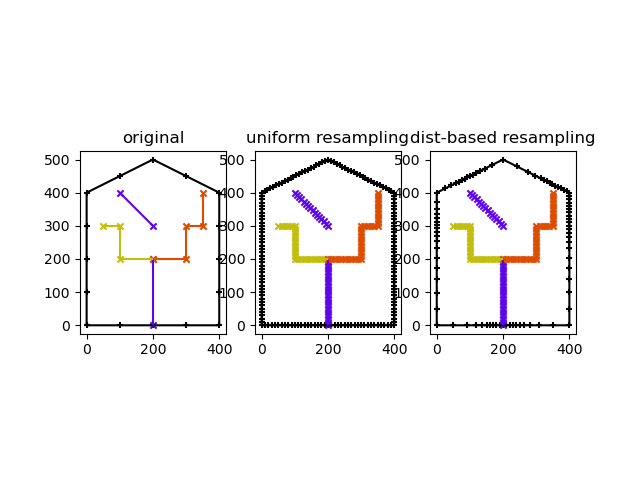

In [26]:
# plot the results
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ws.plot(color='k', marker='+', markersize=20, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=20, ax=ax)

fig, axs = plt.subplots(1,3)
plot(watershed_orig, rivers_orig, axs[0])
axs[0].set_title('original')

plot(watershed1, rivers1, axs[1])
axs[1].set_title('uniform resampling')

plot(watershed2, rivers2, axs[2])
axs[2].set_title('dist-based resampling')


## Surface Meshing

2025-10-28 15:12:46,303 - root - INFO: 
2025-10-28 15:12:46,303 - root - INFO: Stream-aligned Meshing
2025-10-28 15:12:46,303 - root - INFO: ------------------------------
2025-10-28 15:12:46,304 - root - INFO: Creating stream-aligned mesh...
2025-10-28 15:12:46,316 - root - INFO: Adjusting HUC to match reaches at outlet
2025-10-28 15:12:46,324 - root - INFO: 
2025-10-28 15:12:46,324 - root - INFO: Triangulation
2025-10-28 15:12:46,324 - root - INFO: ------------------------------
2025-10-28 15:12:46,325 - root - INFO: Triangulating...
2025-10-28 15:12:46,326 - root - INFO:    277 points and 278 facets
2025-10-28 15:12:46,326 - root - INFO:  checking graph consistency
2025-10-28 15:12:46,327 - root - INFO:  tolerance is set to 0.1
2025-10-28 15:12:46,328 - root - INFO:  building graph data structures
2025-10-28 15:12:46,330 - root - INFO:  triangle.build...
2025-10-28 15:12:51,454 - root - INFO:   ...built: 872 mesh points and 1467 triangles
2025-10-28 15:12:51,454 - root - INFO: Plott

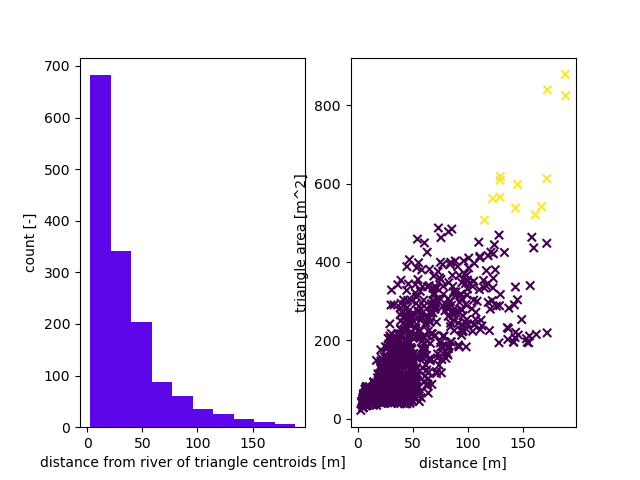

In [27]:
## Triangulation
refine_d0 = 12
refine_d1 = 18
refine_A0 = 82
refine_A1 = 500
d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 

# Refine triangles if they get too acute
min_angle = 32 # degrees

# width of reach by stream order (order:width) or integer
widths = 5.0

# created two versions of the discrete watershed and rivers -- let's use the second one
watershed, rivers = createCopy(watershed2, rivers2)

#info = watershed_workflow.tessalateRiverAligned(watershed, rivers, river_width=widths, diagnostics=True)

m2, areas, dists = watershed_workflow.tessalateRiverAligned(watershed, rivers, river_width=widths,
                                              refine_min_angle=min_angle, refine_distance=[d0,A0,d1,A1],
                                              tol=0.1, diagnostics=True)

<Axes: >

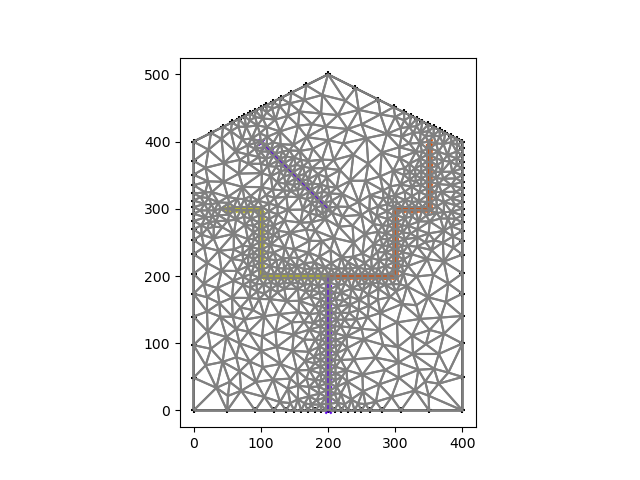

In [28]:
# plot the mesh
fig, ax = plt.subplots(1,1)
plot(watershed, rivers, ax=ax)

df_mesh = gpd.GeoDataFrame(geometry=[shapely.geometry.Polygon(m2.coords[c, :]) for c in m2.conn])
df_mesh.boundary.plot(ax=ax, color='grey')
        



In [29]:
mls = shapely.geometry.MultiLineString([reach.linestring for river in rivers for reach in river.preOrder()])
dist = np.array([shapely.geometry.Point(coord).distance(mls) for  coord in m2.coords])

In [30]:
# providing elevations to each point of the mesh (real case this would come from DEMs)
points3=np.zeros((len(m2.coords),3))
points3[:,:2]=m2.coords
points3[:,2]=9+dist/200+m2.coords[:,1]/400 # grad

m2.coords = points3

In [31]:
# depress the river corridor to burn in streams
def conditionRiverMesh(m2, river, depress_by):
    m2_copy = copy.deepcopy(m2)
    for reach in river:
        for i, elem in enumerate(reach['elems']):
            for j in range(len(elem)):
                m2.coords[elem[j]][2] = m2_copy.coords[elem[j]][2] - depress_by

for river in rivers:
    conditionRiverMesh(m2, river, 1)

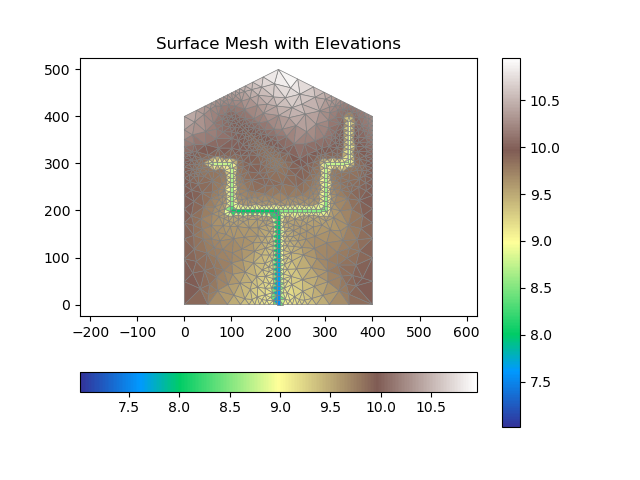

In [32]:
# plotting surface mesh with elevations
fig, ax = plt.subplots(1,1)
# Get elevation data range
elev_min = m2.coords[:,2].min()
elev_max = m2.coords[:,2].max()
# Create normalized colormap
norm = plt.Normalize(vmin=elev_min, vmax=elev_max)
mp = m2.plot(facecolors='elevation', ax=ax, linewidth=0.5, cmap='terrain', norm = norm)
cbar = fig.colorbar(mp, orientation="horizontal")
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')
plt.title('Surface Mesh with Elevations')
plt.show()

## Mesh Extrusion

In [33]:
## **** Creating a 3D mesh

# this is oversimplified case where we wille xtrude this mesh in 3D with 10 layers of prescribed thicknesses

total_thickness = 10
dzs=[0.1,0.2, 0.2, 0.25,0.25,0.25,0.25,1,1.25,1.25,2,3]
print(sum(dzs))
assert(sum(dzs)==total_thickness)

# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

depth = 0
for dz in dzs:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1000)
  
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarizeExtrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2025-10-28 15:12:52,232 - root - INFO: Cell summary:
2025-10-28 15:12:52,258 - root - INFO: ------------------------------------------------------------
2025-10-28 15:12:52,263 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2025-10-28 15:12:52,264 - root - INFO: ------------------------------------------------------------
2025-10-28 15:12:52,264 - root - INFO:  00 	| 00 	| 1000 	|   0.100000 	|   0.000000
2025-10-28 15:12:52,264 - root - INFO:  01 	| 01 	| 1000 	|   0.200000 	|   0.100000
2025-10-28 15:12:52,265 - root - INFO:  02 	| 02 	| 1000 	|   0.200000 	|   0.300000
2025-10-28 15:12:52,265 - root - INFO:  03 	| 03 	| 1000 	|   0.250000 	|   0.500000
2025-10-28 15:12:52,265 - root - INFO:  04 	| 04 	| 1000 	|   0.250000 	|   0.750000
2025-10-28 15:12:52,265 - root - INFO:  05 	| 05 	| 1000 	|   0.250000 	|   1.000000
2025-10-28 15:12:52,266 - root - INFO:  06 	| 06 	| 1000 	|   0.250000 	|   1.250000
2025-10-28 15:12:52,266 - root - INFO:  07 	| 07 	| 1000 	|   1.000000 	|   1.5

10.0


In [34]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2,layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)


## Mesh IO

Save the mesh file as an Exodus II file.

In [35]:
# saving mesh as exodus file
if os.path.isfile('demo_mixed_element_mesh.exo'):
    os.remove('demo_mixed_element_mesh.exo')

m3.writeExodus('demo_mixed_element_mesh.exo')

ImportError: The python ExodusII wrappers were not found, please see the installation documentation to install Exodus